In [1]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install ogb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 7.9 MB 34.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 3.5 MB 19.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 467 kB 20.7 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=d9be1e99bfd0ec80aff7f1f1289046f2da982f305dd57747feedf63bdcb53941
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-w

In [2]:
import torch
import torch_geometric
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import negative_sampling

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from ogb.linkproppred import PygLinkPropPredDataset
dataset = PygLinkPropPredDataset(name='ogbl-ddi')

Downloaded 0.04 GB: 100%|██████████| 46/46 [00:06<00:00,  7.25it/s]


Extracting dataset/ddi.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 35.59it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 1352.56it/s]

Saving...



Done!


In [5]:
ddi_graph = dataset[0]
ddi_graph.num_nodes

4267

In [6]:
ddi_graph.num_edges

2135822

In [7]:
ddi_graph.is_undirected()

True

In [8]:
ddi_graph.num_node_features

0

In [9]:
ddi_graph.has_isolated_nodes()

False

In [10]:
ddi_graph.has_self_loops()

False

In [11]:
split_edges = dataset.get_edge_split()
train_edges, valid_edges, test_edges = split_edges['train'],split_edges['valid'],split_edges['test']

In [12]:
train_edges["edge"].shape[0]

1067911

In [13]:
valid_edges["edge"].shape[0]

133489

In [14]:
valid_edges["edge_neg"].shape[0]

101882

In [15]:
test_edges["edge"].shape[0]

133489

In [16]:
valid_edges["edge_neg"].shape[0]

101882

In [17]:
class GraphSAGE(torch.nn.Module):
  def __init__(self,conv,in_channels,hidden_channels,out_channels,num_layers,dropout):
    super(GraphSAGE,self).__init__()
    self.convs = torch.nn.ModuleList()
    assert (num_layers>=2), 'Have at least 2 layers'
    self.convs.append(conv(in_channels,hidden_channels,normalize=True))
    for l in range(num_layers - 2):
      self.convs.append(conv(hidden_channels,hidden_channels,normalize=True))
    self.convs.append(conv(hidden_channels,out_channels,normalize=True))
    self.num_layers = num_layers
    self.dropout = dropout

  def forward(self,x,edge_index,edge_attr):
    if edge_attr is not None:
      return self.forward_with_edge_attr(x,edge_index,edge_attr)
    for i in range(self.num_layers - 1):
      x = self.convs[i](x,edge_index)
      x = F.relu(x)
      x = F.dropout(x,p=self.dropout,training=self.training)
    x = self.convs[self.num_layers-1](x,edge_index,edge_attr)
    return x

In [18]:
graphsage_in_channels = 256
graphsage_hidden_channels = 256
graphsage_out_channels = 256
graphsage_num_layers = 2
dropout = 0.5

In [19]:
initial_node_embeddings = torch.nn.Embedding(ddi_graph.num_nodes, graphsage_in_channels).to(device)

In [20]:
graphsage_model = GraphSAGE(SAGEConv, graphsage_in_channels,
                            graphsage_hidden_channels,
                            graphsage_out_channels,
                            graphsage_num_layers,
                            dropout).to(device)

In [21]:
link_predictor_in_channels = graphsage_out_channels
link_predictor_hidden_channels = link_predictor_in_channels

In [22]:
class LinkPredictor(torch.nn.Module):
  def __init__(self,in_channels,hidden_channels,dropout,out_channels=1,
               concat=lambda x,y:x*y):
    super(LinkPredictor,self).__init__()
    self.model = nn.Sequential(nn.Linear(in_channels,hidden_channels),nn.ReLU(),
                               nn.Dropout(p=dropout),nn.Linear(hidden_channels,out_channels),nn.Sigmoid())
    self.concat = concat
  
  def forward(self,u,v):
    x = self.concat(u,v)
    return self.model(x)

In [23]:
link_predictor = LinkPredictor(in_channels=link_predictor_in_channels, 
                               hidden_channels=link_predictor_hidden_channels, 
                               dropout=dropout).to(device)

In [24]:
def train(graphsage_model, link_predictor, initial_node_embeddings, edge_index,
          pos_train_edges, optimizer, batch_size, edge_attr=None):
  total_loss, total_examples = 0,0
  graphsage_model.train()
  link_predictor.train()
  for pos_samples in DataLoader(pos_train_edges, batch_size, shuffle=True):
    optimizer.zero_grad()
    node_embeddings = graphsage_model(initial_node_embeddings,edge_index,edge_attr)
    neg_samples = negative_sampling(edge_index,
                                    num_nodes = initial_node_embeddings.size(0),
                                    num_neg_samples=len(pos_samples),
                                    method='dense')
    pos_preds = link_predictor(node_embeddings[pos_samples[:,0]],
                               node_embeddings[pos_samples[:,1]])
    neg_preds = link_predictor(node_embeddings[neg_samples[0]],
                               node_embeddings[neg_samples[1]])
    preds = torch.concat((pos_preds,neg_preds))
    labels = torch.concat((torch.ones_like(pos_preds),
                           torch.zeros_like(neg_preds)))
    loss = F.binary_cross_entropy(preds,labels)
    loss.backward()
    optimizer.step()
    num_examples = len(pos_preds)
    total_loss += loss.item()*num_examples
    total_examples += num_examples
  return total_loss/total_examples

In [25]:
lr = 0.005
batch_size = 65536
epochs = 50
eval_steps = 5

In [26]:
optimizer = torch.optim.Adam(list(graphsage_model.parameters()) + list(initial_node_embeddings.parameters()) + list(link_predictor.parameters()), lr=lr)

In [27]:
pos_valid_edges = valid_edges['edge'].to(device)
neg_valid_edges = valid_edges['edge_neg'].to(device)
pos_test_edges = test_edges['edge'].to(device)
neg_test_edges = test_edges['edge_neg'].to(device)

In [28]:
from ogb.linkproppred import Evaluator
evaluator = Evaluator(name = 'ogbl-ddi')

In [29]:
@torch.no_grad()
def test(graphsage_model, link_predictor, initial_node_embeddings, edge_index, pos_valid_edges, neg_valid_edges, pos_test_edges, neg_test_edges, batch_size, evaluator, edge_attr=None):
  graphsage_model.eval()
  link_predictor.eval()
  final_node_embeddings = graphsage_model(initial_node_embeddings, edge_index, edge_attr)
  pos_valid_preds = []
  for pos_samples in DataLoader(pos_valid_edges, batch_size):
    pos_preds = link_predictor(final_node_embeddings[pos_samples[:,0]],
                               final_node_embeddings[pos_samples[:,1]])
    pos_valid_preds.append(pos_preds.squeeze())
  pos_valid_pred = torch.cat(pos_valid_preds, dim=0) 
  neg_valid_preds = []
  for neg_samples in DataLoader(neg_valid_edges, batch_size):
    neg_preds = link_predictor(final_node_embeddings[neg_samples[:,0]],
                               final_node_embeddings[neg_samples[:,1]])
    neg_valid_preds.append(neg_preds.squeeze())
  neg_valid_pred = torch.cat(neg_valid_preds, dim=0)
  pos_test_preds = []
  for pos_samples in DataLoader(pos_test_edges, batch_size):
    pos_preds = link_predictor(final_node_embeddings[pos_samples[:,0]],
                               final_node_embeddings[pos_samples[:,1]])
    pos_test_preds.append(pos_preds.squeeze())
  pos_test_pred = torch.cat(pos_test_preds,dim=0)
  neg_test_preds = []
  for neg_samples in DataLoader(neg_test_edges, batch_size):
    neg_preds = link_predictor(final_node_embeddings[neg_samples[:,0]],
                               final_node_embeddings[neg_samples[:,1]])
    neg_test_preds.append(neg_preds.squeeze())
  neg_test_pred = torch.cat(neg_test_preds,dim=0)
  evaluator.K = 20
  valid_hits = evaluator.eval({'y_pred_pos':pos_valid_pred,'y_pred_neg':neg_valid_pred})
  test_hits = evaluator.eval({'y_pred_pos':pos_test_pred,'y_pred_neg':neg_test_pred})
  return valid_hits, test_hits


Loss 0.3255:  10%|█         | 5/50 [00:44<06:35,  8.80s/it]


Epoch: 5, Validation Hits@20: 0.0839, Test Hits@20: 0.0974


Loss 0.2388:  20%|██        | 10/50 [01:26<05:44,  8.61s/it]


Epoch: 10, Validation Hits@20: 0.1848, Test Hits@20: 0.1031


Loss 0.1912:  30%|███       | 15/50 [02:09<05:06,  8.75s/it]


Epoch: 15, Validation Hits@20: 0.2712, Test Hits@20: 0.1538


Loss 0.1645:  40%|████      | 20/50 [02:53<04:34,  9.15s/it]


Epoch: 20, Validation Hits@20: 0.3303, Test Hits@20: 0.1966


Loss 0.1440:  50%|█████     | 25/50 [03:35<03:38,  8.74s/it]


Epoch: 25, Validation Hits@20: 0.3590, Test Hits@20: 0.2840


Loss 0.1308:  60%|██████    | 30/50 [04:17<02:53,  8.65s/it]


Epoch: 30, Validation Hits@20: 0.4569, Test Hits@20: 0.3135


Loss 0.1216:  70%|███████   | 35/50 [05:00<02:10,  8.70s/it]


Epoch: 35, Validation Hits@20: 0.4124, Test Hits@20: 0.3446


Loss 0.1157:  80%|████████  | 40/50 [05:42<01:26,  8.68s/it]


Epoch: 40, Validation Hits@20: 0.4930, Test Hits@20: 0.3960


Loss 0.1116:  90%|█████████ | 45/50 [06:24<00:43,  8.66s/it]


Epoch: 45, Validation Hits@20: 0.4917, Test Hits@20: 0.3294


Loss 0.1072: 100%|██████████| 50/50 [07:06<00:00,  8.53s/it]


Epoch: 50, Validation Hits@20: 0.4925, Test Hits@20: 0.3181


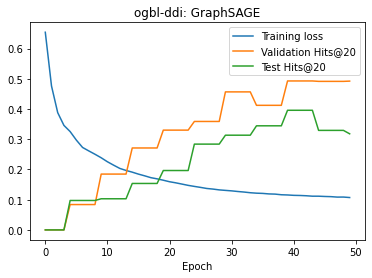

In [30]:
import matplotlib.pyplot as plt
from tqdm import trange
epochs_bar = trange(1, epochs+1,desc='Loss n/a')
edge_index = ddi_graph.edge_index.to(device)
pos_train_edges = train_edges['edge'].to(device)
losses = []
valid_hits_list = []
test_hits_list = []
for epoch in epochs_bar:
  loss = train(graphsage_model, link_predictor, initial_node_embeddings.weight, edge_index, pos_train_edges, optimizer, batch_size)
  losses.append(loss)
  epochs_bar.set_description(f'Loss {loss:0.4f}')
  if epoch%eval_steps == 0:
    valid_hits, test_hits = test(graphsage_model, link_predictor, initial_node_embeddings.weight, edge_index, pos_valid_edges,neg_valid_edges, pos_test_edges, neg_test_edges, batch_size, evaluator)
    print()
    print(f'Epoch: {epoch}, Validation Hits@20: {valid_hits["hits@20"]:0.4f}, Test Hits@20: {test_hits["hits@20"]:0.4f}')
    valid_hits_list.append(valid_hits['hits@20'])
    test_hits_list.append(test_hits['hits@20'])
  else:
    valid_hits_list.append(valid_hits_list[-1] if valid_hits_list else 0)
    test_hits_list.append(test_hits_list[-1] if test_hits_list else 0)

plt.title(dataset.name + ": GraphSAGE")
plt.xlabel("Epoch")
plt.plot(losses, label="Training loss")
plt.plot(valid_hits_list, label="Validation Hits@20")
plt.plot(test_hits_list, label="Test Hits@20")
plt.legend()
plt.show()